# Modeling

## Imports

In [ ]:
# basics
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import numpy as np

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown


# feature selection
from sklearn.decomposition import PCA

# modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score

# google drive
from google.colab import drive
drive.mount('/content/gdrive')

# data
customer_df = pd.read_csv('gdrive/My Drive/Syracuse/6 Big Data/Final Project/telecom_customer_churn.csv')
pop_df = pd.read_csv('gdrive/My Drive/Syracuse/6 Big Data/Final Project/telecom_zipcode_population.csv')

customer_df.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Internet Type,Avg Monthly GB Download,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,9,None,Yes,42.39,No,Yes,Cable,16.0,No,Yes,No,Yes,Yes,No,No,Yes,One Year,Yes,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,9,None,Yes,10.69,Yes,Yes,Cable,10.0,No,No,No,No,No,Yes,Yes,No,Month-to-Month,No,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,4,Offer E,Yes,33.65,No,Yes,Fiber Optic,30.0,No,No,Yes,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,13,Offer D,Yes,27.82,No,Yes,Fiber Optic,4.0,No,Yes,Yes,No,Yes,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,3,None,Yes,7.38,No,Yes,Fiber Optic,11.0,No,No,No,Yes,Yes,No,No,Yes,Month-to-Month,Yes,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


## Cleaning

In [ ]:
# Fill Missing Values

# fill with zeros
fill_zero_cols = ['Avg Monthly Long Distance Charges',
                  'Avg Monthly GB Download']
customer_df[fill_zero_cols] = customer_df[fill_zero_cols].fillna(value=0)

# fill with 'No'
fill_no_cols = ['Multiple Lines',
             'Online Security',
             'Online Backup',
             'Device Protection Plan',
             'Premium Tech Support',
             'Streaming TV',
             'Streaming Movies',
             'Streaming Music',
             'Unlimited Data']

customer_df[fill_no_cols] = customer_df[fill_no_cols].fillna(value='No')

# fill with 'None'
customer_df['Internet Type'] = customer_df['Internet Type'].fillna(value = 'None')

customer_df.isna().sum().to_frame().T

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Internet Type,Avg Monthly GB Download,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5174,5174


In [ ]:
# convert Customer Status to a binary
customer_df['binary_customer_status'] = customer_df['Customer Status'].replace({'Joined': 'Stayed'})

In [ ]:
# Add population by zip code

# convert zip code to a string
customer_df['Zip Code'] = customer_df['Zip Code'].apply(lambda x: f'{x:05d}')
pop_df['Zip Code'] = pop_df['Zip Code'].apply(lambda x: f'{x:05d}')

# merge the DataFrames on the Zip Code column
customer_df = pd.merge(customer_df, pop_df, on='Zip Code', how='left')

## Train Test Split

In [ ]:
# split data into features and target
X = customer_df.drop(columns=['Customer Status', 'binary_customer_status', 'Customer ID', 'Zip Code', 'City', 'Churn Category', 'Churn Reason'])
y = customer_df['binary_customer_status']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# combine the training data
train_data = pd.concat([X_train, y_train], axis=1)

## Downsample

In [ ]:
# Separate the DataFrame into two subsets based on the binary target
churned_df = train_data[train_data['binary_customer_status'] == 'Churned'].copy()
stayed_df = train_data[train_data['binary_customer_status'] == 'Stayed'].copy()

# Determine the number of instances in the smaller class
n_min_class = min(churned_df.shape[0], stayed_df.shape[0])

# Downsample the larger class to match the smaller class's size
churned_df_downsampled = churned_df.sample(n=n_min_class, random_state=42) # Adjust random_state for reproducibility
stayed_df_downsampled = stayed_df.sample(n=n_min_class, random_state=42) # Adjust as necessary

# Concatenate the downsampled DataFrames back together
downsampled_train_data = pd.concat([churned_df_downsampled, stayed_df_downsampled])

# Split back into X_train_balanced and y_train_balanced
X_train_downsampled = downsampled_train_data.drop('binary_customer_status', axis=1)
y_train_downsampled = downsampled_train_data['binary_customer_status']

## Upsample

In [ ]:
# Separate the DataFrame into two subsets based on the binary target
churned_df = train_data[train_data['binary_customer_status'] == 'Churned'].copy()
stayed_df = train_data[train_data['binary_customer_status'] == 'Stayed'].copy()

# Determine the number of instances in the larger class
n_max_class = max(churned_df.shape[0], churned_df.shape[0])

# Upsample the smaller class to match the larger class's size
# Replace=False for sampling without replacement, Replace=True for with replacement
churned_df_upsampled = churned_df.sample(n=n_max_class, replace=True, random_state=42) # Adjust random_state for reproducibility
stayed_df_upsampled = stayed_df.sample(n=n_max_class, replace=True, random_state=42) # Adjust as necessary

# Concatenate the upsampled DataFrames back together
upsampled_train_data = pd.concat([churned_df_upsampled, stayed_df_upsampled])

# Split back into X_train_balanced and y_train_balanced
X_train_upsampled = upsampled_train_data.drop('binary_customer_status', axis=1)
y_train_upsampled = upsampled_train_data['binary_customer_status']

## Pipeline

In [ ]:
# split up numerical and categorical columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

# Define preprocessing for numerical and categorical data
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])  # Placeholder, will be replaced in grid search
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

# Combine preprocessing steps
preprocessor = Pipeline(steps=[
    ('col_transformer', ColumnTransformer(
      transformers=[
          ('num', numerical_transformer, numerical_cols),
          ('cat', categorical_transformer, categorical_cols)
      ])),
    ('pca', 'passthrough'),  # Initially set to 'passthrough' to potentially skip PCA
    ])


# Create a preprocessing and modeling pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression())])

## GridSearchCV Parameters

# Train Data: Unbalanced Data 

## Train Data: Unbalanced Data 

## Classifier: Logistic Regression 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best parameters: {'classifier': LogisticRegression(C=1), 'classifier__C': 1, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': PCA(n_components=38)}
Best score: 0.8406112835125557
Test accuracy: 0.837473385379702
Confusion Matrix:
 [[250 123]
 [106 930]]

Classification Report:
               precision    recall  f1-score   support

     Churned       0.70      0.67      0.69       373
      Stayed       0.88      0.90      0.89      1036

    accuracy                           0.84      1409
   macro avg       0.79      0.78      0.79      1409
weighted avg       0.84      0.84      0.84      1409



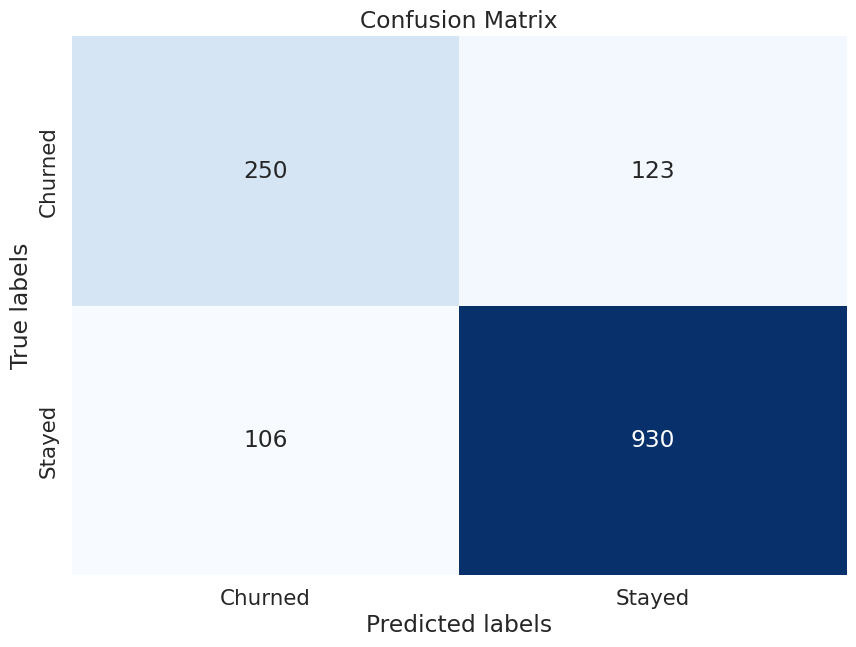

,mean_test_score,params
20,0.840611,"{'classifier': LogisticRegression(C=1), 'classifier__C': 1, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': PCA(n_components=38)}"
2,0.840256,"{'classifier': LogisticRegression(C=1), 'classifier__C': 0.1, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=38)}"
3,0.839724,"{'classifier': LogisticRegression(C=1), 'classifier__C': 0.1, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=40)}"
5,0.839724,"{'classifier': LogisticRegression(C=1), 'classifier__C': 0.1, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': 'passthrough'}"
21,0.839191,"{'classifier': LogisticRegression(C=1), 'classifier__C': 1, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': PCA(n_components=40)}"
23,0.839191,"{'classifier': LogisticRegression(C=1), 'classifier__C': 1, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': 'passthrough'}"
32,0.839191,"{'classifier': LogisticRegression(C=1), 'classifier__C': 10, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': PCA(n_components=38)}"
15,0.839013,"{'classifier': LogisticRegression(C=1), 'classifier__C': 1, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=40)}"
44,0.838836,"{'classifier': LogisticRegression(C=1), 'classifier__C': 100, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': PCA(n_components=38)}"
14,0.838836,"{'classifier': LogisticRegression(C=1), 'classifier__C': 1, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=38)}"


## Train Data: Unbalanced Data 

## Classifier: Random Forest Classifier 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.10/dist-pa

Best parameters: {'classifier': RandomForestClassifier(n_estimators=500, random_state=42), 'classifier__n_estimators': 500, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': 'passthrough'}
Best score: 0.8436286152425293
Test accuracy: 0.836763662171753
Confusion Matrix:
 [[217 156]
 [ 74 962]]

Classification Report:
               precision    recall  f1-score   support

     Churned       0.75      0.58      0.65       373
      Stayed       0.86      0.93      0.89      1036

    accuracy                           0.84      1409
   macro avg       0.80      0.76      0.77      1409
weighted avg       0.83      0.84      0.83      1409



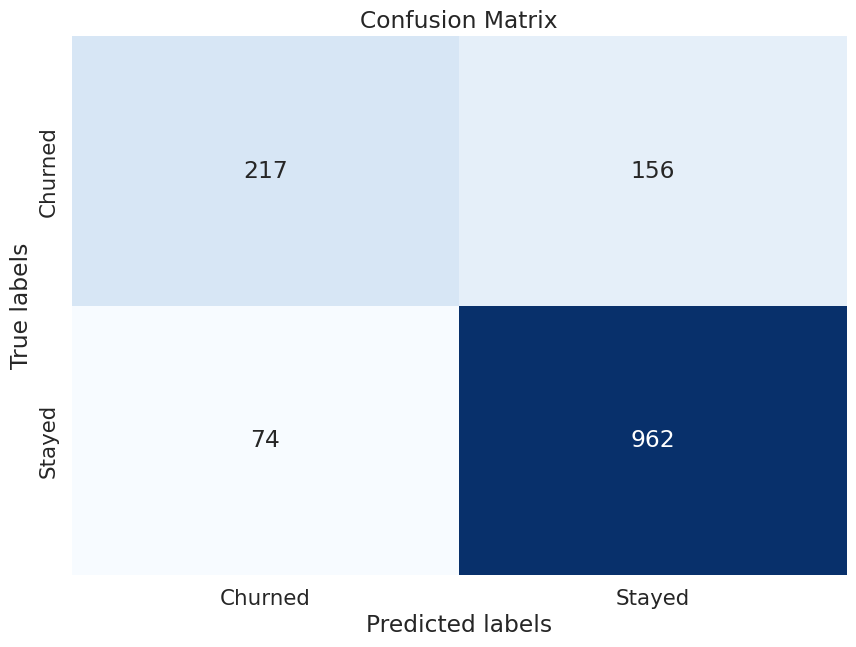

,mean_test_score,params
29,0.843629,"{'classifier': RandomForestClassifier(n_estimators=500, random_state=42), 'classifier__n_estimators': 500, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': 'passthrough'}"
35,0.842919,"{'classifier': RandomForestClassifier(n_estimators=500, random_state=42), 'classifier__n_estimators': 500, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': 'passthrough'}"
11,0.842742,"{'classifier': RandomForestClassifier(n_estimators=500, random_state=42), 'classifier__n_estimators': 100, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': 'passthrough'}"
5,0.842387,"{'classifier': RandomForestClassifier(n_estimators=500, random_state=42), 'classifier__n_estimators': 100, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': 'passthrough'}"
17,0.842386,"{'classifier': RandomForestClassifier(n_estimators=500, random_state=42), 'classifier__n_estimators': 200, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': 'passthrough'}"
23,0.842208,"{'classifier': RandomForestClassifier(n_estimators=500, random_state=42), 'classifier__n_estimators': 200, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': 'passthrough'}"
32,0.840612,"{'classifier': RandomForestClassifier(n_estimators=500, random_state=42), 'classifier__n_estimators': 500, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': PCA(n_components=38)}"
8,0.839902,"{'classifier': RandomForestClassifier(n_estimators=500, random_state=42), 'classifier__n_estimators': 100, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': PCA(n_components=38)}"
20,0.839193,"{'classifier': RandomForestClassifier(n_estimators=500, random_state=42), 'classifier__n_estimators': 200, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': PCA(n_components=38)}"
33,0.839192,"{'classifier': RandomForestClassifier(n_estimators=500, random_state=42), 'classifier__n_estimators': 500, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': PCA(n_components=40)}"


## Train Data: Unbalanced Data 

## Classifier: Support Vector Machine 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.10/dist-pa

Best parameters: {'classifier': SVC(C=1), 'classifier__C': 1, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': 'passthrough'}
Best score: 0.8384817360413932
Test accuracy: 0.843860894251242
Confusion Matrix:
 [[238 135]
 [ 85 951]]

Classification Report:
               precision    recall  f1-score   support

     Churned       0.74      0.64      0.68       373
      Stayed       0.88      0.92      0.90      1036

    accuracy                           0.84      1409
   macro avg       0.81      0.78      0.79      1409
weighted avg       0.84      0.84      0.84      1409



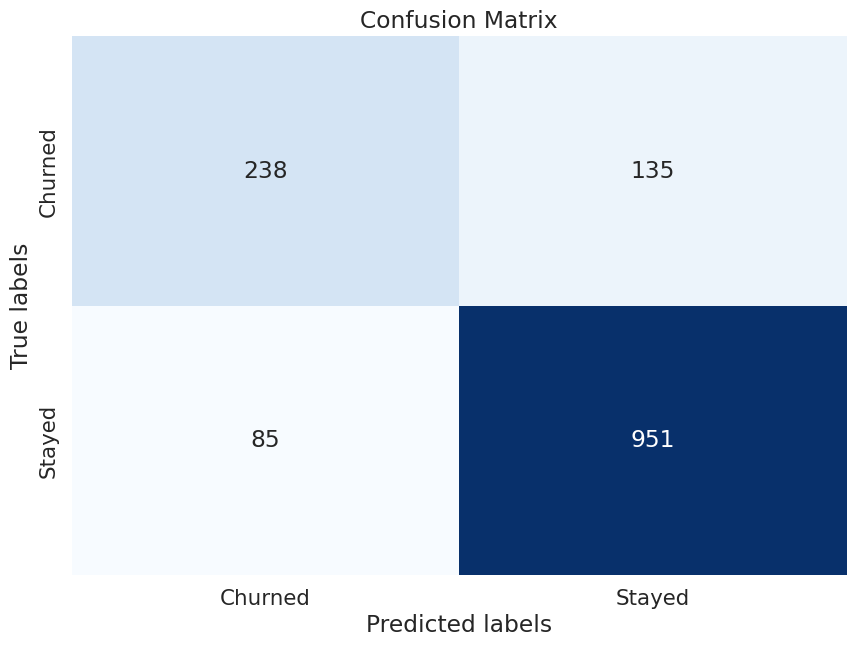

,mean_test_score,params
17,0.838482,"{'classifier': SVC(C=1), 'classifier__C': 1, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': 'passthrough'}"
21,0.837773,"{'classifier': SVC(C=1), 'classifier__C': 1, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': PCA(n_components=40)}"
14,0.837595,"{'classifier': SVC(C=1), 'classifier__C': 1, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=38)}"
20,0.837417,"{'classifier': SVC(C=1), 'classifier__C': 1, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': PCA(n_components=38)}"
15,0.837417,"{'classifier': SVC(C=1), 'classifier__C': 1, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=40)}"
23,0.837240,"{'classifier': SVC(C=1), 'classifier__C': 1, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': 'passthrough'}"
26,0.829253,"{'classifier': SVC(C=1), 'classifier__C': 10, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=38)}"
29,0.828365,"{'classifier': SVC(C=1), 'classifier__C': 10, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': 'passthrough'}"
27,0.828365,"{'classifier': SVC(C=1), 'classifier__C': 10, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=40)}"
19,0.826058,"{'classifier': SVC(C=1), 'classifier__C': 1, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': PCA(n_components=24)}"


# Train Data: Downsampled Data 

## Train Data: Downsampled Data 

## Classifier: Logistic Regression 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best parameters: {'classifier': LogisticRegression(C=1), 'classifier__C': 1, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': PCA(n_components=40)}
Best score: 0.8128329825070771
Test accuracy: 0.7828246983676366
Confusion Matrix:
 [[315  58]
 [248 788]]

Classification Report:
               precision    recall  f1-score   support

     Churned       0.56      0.84      0.67       373
      Stayed       0.93      0.76      0.84      1036

    accuracy                           0.78      1409
   macro avg       0.75      0.80      0.76      1409
weighted avg       0.83      0.78      0.79      1409



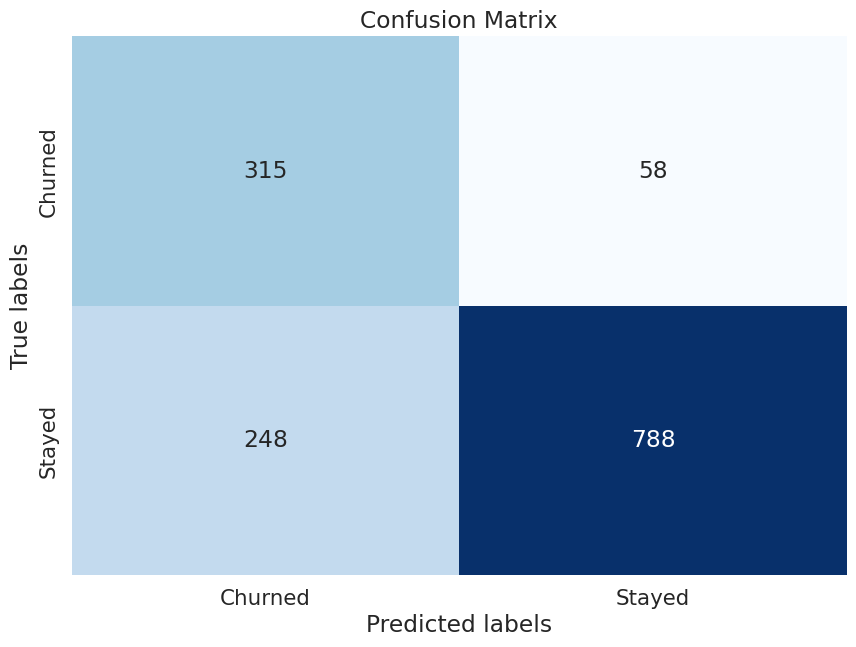

,mean_test_score,params
23,0.812833,"{'classifier': LogisticRegression(C=1), 'classifier__C': 1, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': 'passthrough'}"
21,0.812833,"{'classifier': LogisticRegression(C=1), 'classifier__C': 1, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': PCA(n_components=40)}"
20,0.811830,"{'classifier': LogisticRegression(C=1), 'classifier__C': 1, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': PCA(n_components=38)}"
44,0.811495,"{'classifier': LogisticRegression(C=1), 'classifier__C': 100, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': PCA(n_components=38)}"
38,0.811495,"{'classifier': LogisticRegression(C=1), 'classifier__C': 100, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=38)}"
32,0.810826,"{'classifier': LogisticRegression(C=1), 'classifier__C': 10, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': PCA(n_components=38)}"
26,0.810826,"{'classifier': LogisticRegression(C=1), 'classifier__C': 10, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=38)}"
29,0.809489,"{'classifier': LogisticRegression(C=1), 'classifier__C': 10, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': 'passthrough'}"
27,0.809489,"{'classifier': LogisticRegression(C=1), 'classifier__C': 10, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=40)}"
35,0.809489,"{'classifier': LogisticRegression(C=1), 'classifier__C': 10, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': 'passthrough'}"


## Train Data: Downsampled Data 

## Classifier: Random Forest Classifier 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.10/dist-pa

Best parameters: {'classifier': RandomForestClassifier(n_estimators=500, random_state=42), 'classifier__n_estimators': 500, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': 'passthrough'}
Best score: 0.8145041066214036
Test accuracy: 0.8026969481902059
Confusion Matrix:
 [[309  64]
 [214 822]]

Classification Report:
               precision    recall  f1-score   support

     Churned       0.59      0.83      0.69       373
      Stayed       0.93      0.79      0.86      1036

    accuracy                           0.80      1409
   macro avg       0.76      0.81      0.77      1409
weighted avg       0.84      0.80      0.81      1409



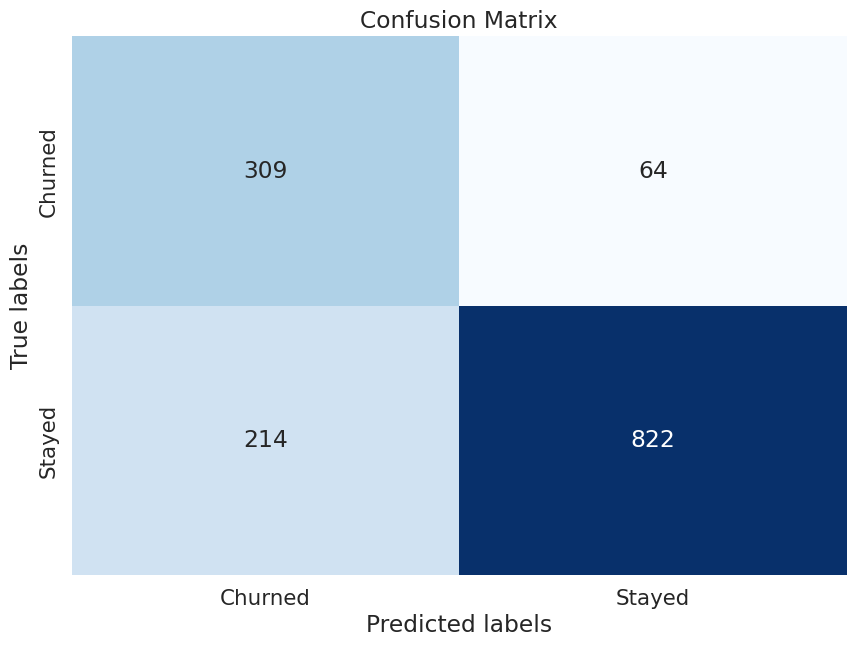

,mean_test_score,params
35,0.814504,"{'classifier': RandomForestClassifier(n_estimators=500, random_state=42), 'classifier__n_estimators': 500, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': 'passthrough'}"
29,0.813502,"{'classifier': RandomForestClassifier(n_estimators=500, random_state=42), 'classifier__n_estimators': 500, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': 'passthrough'}"
26,0.812834,"{'classifier': RandomForestClassifier(n_estimators=500, random_state=42), 'classifier__n_estimators': 500, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=38)}"
27,0.812167,"{'classifier': RandomForestClassifier(n_estimators=500, random_state=42), 'classifier__n_estimators': 500, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=40)}"
23,0.810831,"{'classifier': RandomForestClassifier(n_estimators=500, random_state=42), 'classifier__n_estimators': 200, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': 'passthrough'}"
15,0.810165,"{'classifier': RandomForestClassifier(n_estimators=500, random_state=42), 'classifier__n_estimators': 200, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=40)}"
17,0.809494,"{'classifier': RandomForestClassifier(n_estimators=500, random_state=42), 'classifier__n_estimators': 200, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': 'passthrough'}"
14,0.809161,"{'classifier': RandomForestClassifier(n_estimators=500, random_state=42), 'classifier__n_estimators': 200, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=38)}"
3,0.808494,"{'classifier': RandomForestClassifier(n_estimators=500, random_state=42), 'classifier__n_estimators': 100, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=40)}"
1,0.808486,"{'classifier': RandomForestClassifier(n_estimators=500, random_state=42), 'classifier__n_estimators': 100, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=24)}"


## Train Data: Downsampled Data 

## Classifier: Support Vector Machine 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.10/dist-pa

Best parameters: {'classifier': SVC(C=1), 'classifier__C': 1, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': 'passthrough'}
Best score: 0.8088246296782262
Test accuracy: 0.7693399574166075
Confusion Matrix:
 [[316  57]
 [268 768]]

Classification Report:
               precision    recall  f1-score   support

     Churned       0.54      0.85      0.66       373
      Stayed       0.93      0.74      0.83      1036

    accuracy                           0.77      1409
   macro avg       0.74      0.79      0.74      1409
weighted avg       0.83      0.77      0.78      1409



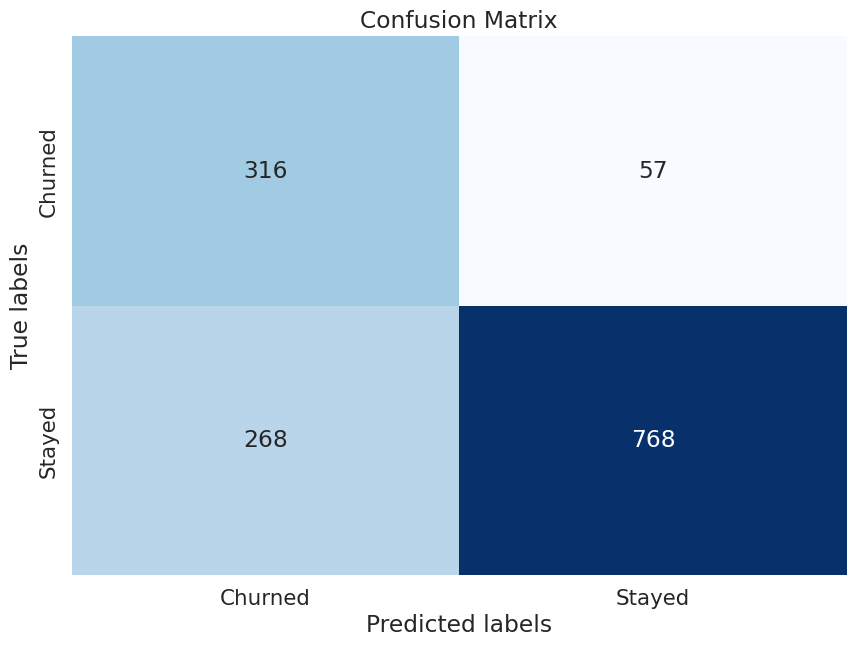

,mean_test_score,params
23,0.808825,"{'classifier': SVC(C=1), 'classifier__C': 1, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': 'passthrough'}"
21,0.807821,"{'classifier': SVC(C=1), 'classifier__C': 1, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': PCA(n_components=40)}"
20,0.807821,"{'classifier': SVC(C=1), 'classifier__C': 1, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': PCA(n_components=38)}"
17,0.806820,"{'classifier': SVC(C=1), 'classifier__C': 1, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': 'passthrough'}"
15,0.806487,"{'classifier': SVC(C=1), 'classifier__C': 1, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=40)}"
14,0.806487,"{'classifier': SVC(C=1), 'classifier__C': 1, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=38)}"
29,0.802472,"{'classifier': SVC(C=1), 'classifier__C': 10, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': 'passthrough'}"
26,0.797458,"{'classifier': SVC(C=1), 'classifier__C': 10, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=38)}"
27,0.797123,"{'classifier': SVC(C=1), 'classifier__C': 10, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=40)}"
35,0.794114,"{'classifier': SVC(C=1), 'classifier__C': 10, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': 'passthrough'}"


# Train Data: Upsampled Data 

## Train Data: Upsampled Data 

## Classifier: Logistic Regression 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best parameters: {'classifier': LogisticRegression(C=100), 'classifier__C': 100, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=40)}
Best score: 0.8308753161623889
Test accuracy: 0.7885024840312278
Confusion Matrix:
 [[312  61]
 [237 799]]

Classification Report:
               precision    recall  f1-score   support

     Churned       0.57      0.84      0.68       373
      Stayed       0.93      0.77      0.84      1036

    accuracy                           0.79      1409
   macro avg       0.75      0.80      0.76      1409
weighted avg       0.83      0.79      0.80      1409



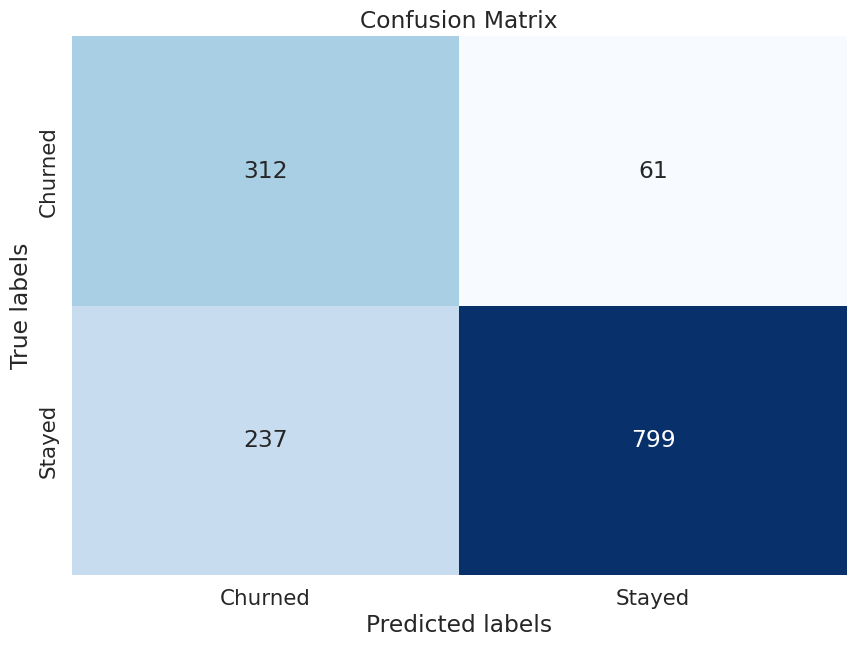

,mean_test_score,params
41,0.830875,"{'classifier': LogisticRegression(C=100), 'classifier__C': 100, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': 'passthrough'}"
39,0.830875,"{'classifier': LogisticRegression(C=100), 'classifier__C': 100, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=40)}"
47,0.830541,"{'classifier': LogisticRegression(C=100), 'classifier__C': 100, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': 'passthrough'}"
45,0.830541,"{'classifier': LogisticRegression(C=100), 'classifier__C': 100, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': PCA(n_components=40)}"
15,0.830208,"{'classifier': LogisticRegression(C=100), 'classifier__C': 1, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=40)}"
17,0.830208,"{'classifier': LogisticRegression(C=100), 'classifier__C': 1, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': 'passthrough'}"
38,0.829873,"{'classifier': LogisticRegression(C=100), 'classifier__C': 100, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=38)}"
29,0.829873,"{'classifier': LogisticRegression(C=100), 'classifier__C': 10, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': 'passthrough'}"
27,0.829873,"{'classifier': LogisticRegression(C=100), 'classifier__C': 10, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=40)}"
26,0.829873,"{'classifier': LogisticRegression(C=100), 'classifier__C': 10, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=38)}"


## Train Data: Upsampled Data 

## Classifier: Random Forest Classifier 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.10/dist-pa

Best parameters: {'classifier': RandomForestClassifier(n_estimators=200, random_state=42), 'classifier__n_estimators': 200, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': 'passthrough'}
Best score: 0.8897102752078435
Test accuracy: 0.8055358410220014
Confusion Matrix:
 [[288  85]
 [189 847]]

Classification Report:
               precision    recall  f1-score   support

     Churned       0.60      0.77      0.68       373
      Stayed       0.91      0.82      0.86      1036

    accuracy                           0.81      1409
   macro avg       0.76      0.79      0.77      1409
weighted avg       0.83      0.81      0.81      1409



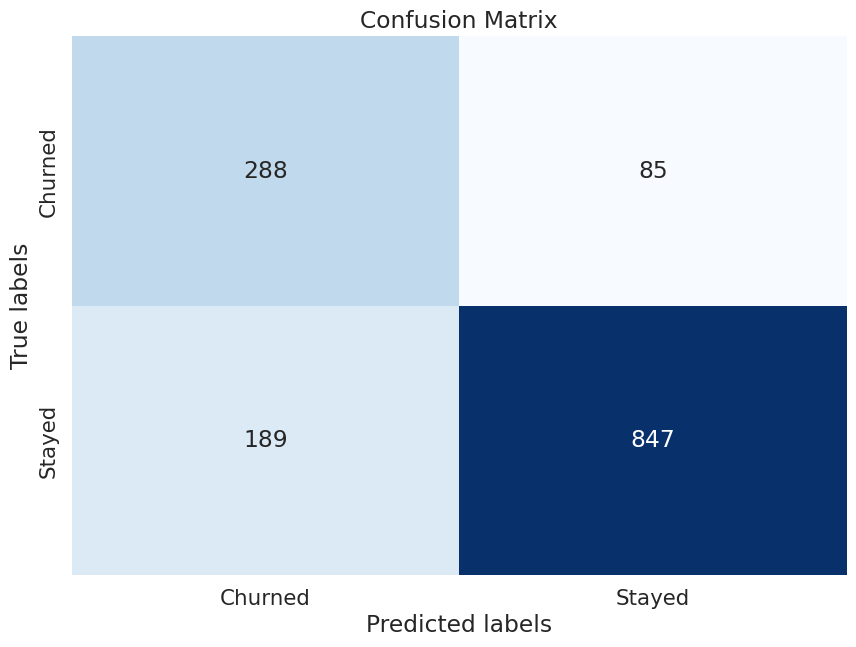

,mean_test_score,params
17,0.889710,"{'classifier': RandomForestClassifier(n_estimators=200, random_state=42), 'classifier__n_estimators': 200, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': 'passthrough'}"
23,0.889376,"{'classifier': RandomForestClassifier(n_estimators=200, random_state=42), 'classifier__n_estimators': 200, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': 'passthrough'}"
29,0.887707,"{'classifier': RandomForestClassifier(n_estimators=200, random_state=42), 'classifier__n_estimators': 500, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': 'passthrough'}"
35,0.887372,"{'classifier': RandomForestClassifier(n_estimators=200, random_state=42), 'classifier__n_estimators': 500, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': 'passthrough'}"
15,0.887366,"{'classifier': RandomForestClassifier(n_estimators=200, random_state=42), 'classifier__n_estimators': 200, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=40)}"
27,0.887034,"{'classifier': RandomForestClassifier(n_estimators=200, random_state=42), 'classifier__n_estimators': 500, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=40)}"
33,0.886700,"{'classifier': RandomForestClassifier(n_estimators=200, random_state=42), 'classifier__n_estimators': 500, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': PCA(n_components=40)}"
14,0.885361,"{'classifier': RandomForestClassifier(n_estimators=200, random_state=42), 'classifier__n_estimators': 200, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=38)}"
8,0.885031,"{'classifier': RandomForestClassifier(n_estimators=200, random_state=42), 'classifier__n_estimators': 100, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': PCA(n_components=38)}"
2,0.885026,"{'classifier': RandomForestClassifier(n_estimators=200, random_state=42), 'classifier__n_estimators': 100, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=38)}"


## Train Data: Upsampled Data 

## Classifier: Support Vector Machine 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.10/dist-pa

Best parameters: {'classifier': SVC(C=10), 'classifier__C': 10, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=40)}
Best score: 0.8766757304537662
Test accuracy: 0.7828246983676366
Confusion Matrix:
 [[298  75]
 [231 805]]

Classification Report:
               precision    recall  f1-score   support

     Churned       0.56      0.80      0.66       373
      Stayed       0.91      0.78      0.84      1036

    accuracy                           0.78      1409
   macro avg       0.74      0.79      0.75      1409
weighted avg       0.82      0.78      0.79      1409



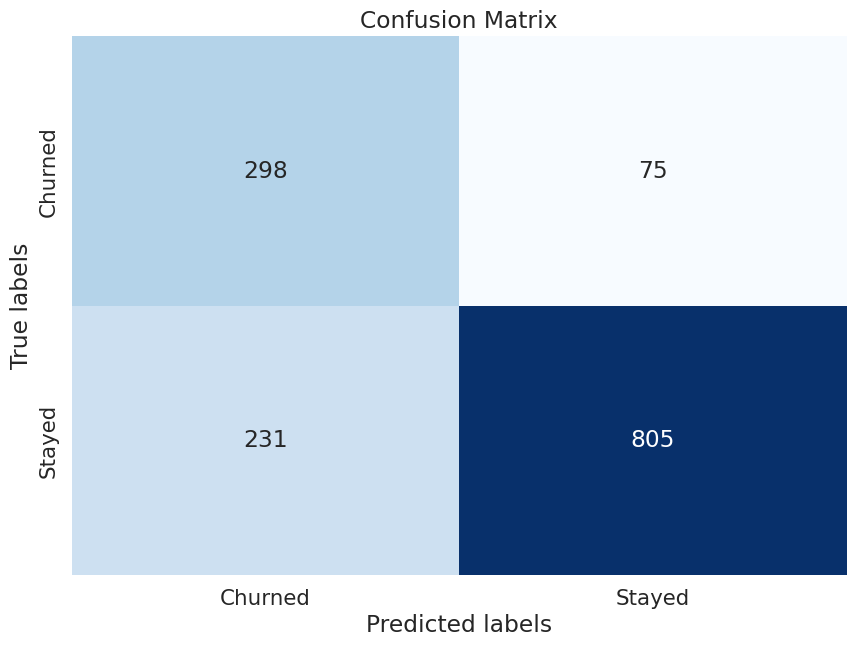

,mean_test_score,params
27,0.876676,"{'classifier': SVC(C=10), 'classifier__C': 10, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=40)}"
26,0.876675,"{'classifier': SVC(C=10), 'classifier__C': 10, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=38)}"
29,0.876341,"{'classifier': SVC(C=10), 'classifier__C': 10, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': 'passthrough'}"
39,0.875671,"{'classifier': SVC(C=10), 'classifier__C': 100, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=40)}"
38,0.874334,"{'classifier': SVC(C=10), 'classifier__C': 100, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=38)}"
41,0.872664,"{'classifier': SVC(C=10), 'classifier__C': 100, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': 'passthrough'}"
33,0.872662,"{'classifier': SVC(C=10), 'classifier__C': 10, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': PCA(n_components=40)}"
32,0.871326,"{'classifier': SVC(C=10), 'classifier__C': 10, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': PCA(n_components=38)}"
47,0.867646,"{'classifier': SVC(C=10), 'classifier__C': 100, 'preprocessor__col_transformer__num__scaler': MinMaxScaler(), 'preprocessor__pca': 'passthrough'}"
25,0.867315,"{'classifier': SVC(C=10), 'classifier__C': 10, 'preprocessor__col_transformer__num__scaler': StandardScaler(), 'preprocessor__pca': PCA(n_components=24)}"


In [ ]:
train_data_list = [
    (X_train, y_train, 'Unbalanced Data'),
    (X_train_downsampled, y_train_downsampled, 'Downsampled Data'),
    (X_train_upsampled, y_train_upsampled, 'Upsampled Data')
]

classifier_list = [
    (
        LogisticRegression(),
        {
            'classifier__C': [0.1, 1, 10, 100],
            #'classifier__penalty': ['l1', 'l2'],
            #'classifier__solver': ['liblinear', 'saga']
        },
        'Logistic Regression'
    ),
    (
        RandomForestClassifier(random_state=42),
        {
            'classifier__n_estimators': [100, 200, 500],
            #'classifier__max_depth': [None, 10, 20, 30],
            #'classifier__min_samples_split': [2, 5, 10],
            #'classifier__min_samples_leaf': [1, 2, 4]
        },
        'Random Forest Classifier'
    ),
    (
        SVC(),
        {
            'classifier__C': [0.1, 1, 10, 100],
            #'classifier__kernel': ['linear', 'rbf', 'poly'],
            #'classifier__gamma': ['scale', 'auto']
        },
        'Support Vector Machine'
    )
]


for train_data in train_data_list:
  display(Markdown(f'# Train Data: {train_data[2]} '))
  for classifier in classifier_list:
    display(Markdown(f'## Train Data: {train_data[2]} '))
    display(Markdown(f'## Classifier: {classifier[2]} '))
    # Define the parameter grid to test
    param_grid = {
        'preprocessor__col_transformer__num__scaler': [
            StandardScaler(),  # Standardization
            MinMaxScaler(),    # Min-Max Normalization
        ],
        'preprocessor__pca': [PCA(n_components=n) for n in [10, 24, 38, 40, 45]] + ['passthrough'],  # Include PCA with various components or skip it
        'classifier': [classifier[0]]
    }

    param_grid.update(classifier[1])

    # Set up the grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

    # Fit the model
    grid_search.fit(train_data[0], train_data[1])

    # Print the best parameters and the best score
    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)

    # Predict and evaluate the model
    y_pred = grid_search.predict(X_test)
    print(f"Test accuracy: {accuracy_score(y_test, y_pred)}")
    #print("ROC AUC Score:", roc_auc_score(y_test, grid_search.predict_proba(X_test)))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Create labels for the matrix axes from the unique values in the true labels and predictions
    labels = np.unique(np.concatenate((y_test, y_pred)))

    # Plot using seaborn
    plt.figure(figsize=(10, 7))  # Increase figure size for better readability
    sns.set(font_scale=1.4)  # Increase font size
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)

    # Add labels and a title
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')

    plt.show()



    # Assuming `grid_search` is your fitted GridSearchCV object
    results = pd.DataFrame(grid_search.cv_results_)

    # Selecting only the columns of interest
    columns_of_interest = ['mean_test_score', 'params']

    # If you want to see all parameters and scores, you could adjust columns_of_interest accordingly
    # Displaying the DataFrame
    display(results[columns_of_interest].sort_values(by='mean_test_score', ascending=False))

In [ ]:
y_test.value_counts()

Stayed     1036
Churned     373
Name: binary_customer_status, dtype: int64